***RNN Model - LSTM***

Reference: OMKAR MODI https://www.kaggle.com/omkarmodi/inceptionv3-feature-extraction/notebook

In [ ]:
#This Program imports a dataset obtained from Kaggle
#https://www.kaggle.com/aryashah2k/breast-ultrasound-images-dataset
#It then classifies the Ultrasound Images as benign, malignant, or normal

import numpy as np # linear algebra
import pandas as pd # data processing

import os

In [ ]:
pip install openpyxl

In [ ]:
from tensorflow import keras
import cv2
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D,BatchNormalization
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D,AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import dataset
path = "drive/MyDrive/EE258 Project/Dataset_BUSI_with_GT"
dir_list = [os.path.join(path,i) for i in os.listdir(path)]
size_dict = {}
for i,value in enumerate(dir_list):
    size_dict[os.listdir(path)[i]] = len(os.listdir(value))
size_dict 

{'benign': 891, 'malignant': 421, 'normal': 266}

In [ ]:
import re
def clean(name):
    name = re.sub('[benign ().p]','',str(name))
    return name

In [ ]:
df = pd.DataFrame(os.listdir(dir_list[0]))

df = df[0].apply(clean)

df = df[~df.str.contains('mask',regex =False)]

df_list = list(df)
type(df_list)
df_list.sort()
print(len(df_list))

133


In [ ]:
#image size
img_size = 128
img_channel = 3
#sets X as a blank matrix of zeros
#y is the actual matrix of the images
X_b , Xm_b , y_b = np.zeros((437,img_size,img_size,img_channel)) , np.zeros((437,img_size,img_size,img_channel)) , np.full(437,'benign') 
X_n , Xm_n , y_n = np.zeros((133,img_size,img_size,img_channel)) , np.zeros((133,img_size,img_size,img_channel)) , np.full(133,'normal') 
X_m , Xm_m , y_m = np.zeros((210,img_size,img_size,img_channel)) , np.zeros((210,img_size,img_size,img_channel)) , np.full(210,'malignant')

In [ ]:
#this block pairs the maked with the ultrasound image
img1_path = os.path.join(os.path.join(path,'benign'),os.listdir(os.path.join(path,'benign'))[1])

pil_img = load_img(img1_path,color_mode = 'rgb',target_size=(img_size,img_size))
img = img_to_array(pil_img)
img_shape = img.shape
print(img_shape)

def img_num(filename):
    
    val = 0
    #this loop looks for image numbers and matches Ultrasound image with masked image
    for i in range(len(filename)) :
        if filename[i] == '(' :
            while True :
                i += 1
                if filename[i] == ')' :
                    break
                val = (val*10) + int(filename[i])
            break
    
    return val
#separates ultrasound and masked images
for tumor_path in dir_list :
    for image in os.listdir(tumor_path) :
        p = os.path.join(tumor_path, image)
        pil_img = load_img(p,color_mode = 'rgb',target_size=(img_size,img_size))         # read image as grayscale and resize it
        
        if image[-5] == ')' :                                   #if real image 
            #Ultrasound images
            if image[0] == 'b' :
                X_b[img_num(image)-1]+= img_to_array(pil_img)  # If image is real add it
            if image[0] == 'n' :                               # to X as benign , normal
                X_n[img_num(image)-1]+= img_to_array(pil_img)  # or malignant.
            if image[0] == 'm' :
                X_m[img_num(image)-1]+= img_to_array(pil_img)
        else :                                                 #else masked image
            #masked image
            if image[0] == 'b' :
                Xm_b[img_num(image)-1]+= img_to_array(pil_img)  # Similarly add the target
            if image[0] == 'n' :                               # mask to y.
                Xm_n[img_num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                Xm_m[img_num(image)-1]+= img_to_array(pil_img)

(128, 128, 3)


In [ ]:
#combining sorted images into matricies
X = np.concatenate((X_b, X_n, X_m), axis = 0) #combining real images into real image matrix {real_b, real_n, real_m}
Xm = np.concatenate((Xm_b, Xm_n, Xm_m), axis = 0) #masked array

#0 is black, 255 is white

y = np.concatenate((y_b, y_n, y_m), axis = 0) #lables

print(X.shape)  #Ultrasound image matrix
print(Xm.shape) #masked image matrix
print(y.shape)  #actual 
#look at max and min 
print(X.max())
print(X.min())
print(Xm.max())
print(Xm.min())

#normalize to max value
X /= 255.0

#normalize to max value
Xm /= 510.0
#combine Ulatrasound Image with Mask
X_combined=X*Xm

#look at max and min 
print(X.max())
print(Xm.min())
print(X_combined.max())
print(X_combined.min())
#look at type
type(y)

(780, 128, 128, 3)
(780, 128, 128, 3)
(780,)
(780, 128, 128, 3)
255.0
0.0
510.0
0.0
1.0
0.0
0.5
0.0


numpy.ndarray

{'malignant': 210}
{'benign': 437}
{'normal': 133}


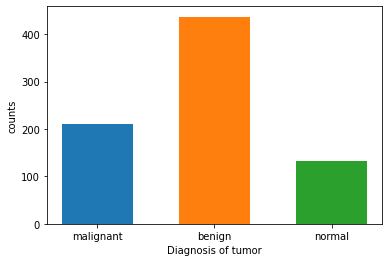

In [ ]:
#Plot Bar Graph

digit_train, counts_train = np.unique(y_m, return_counts = True)
digit_train1, counts_train1 = np.unique(y_b, return_counts = True)
digit_train2, counts_train2 = np.unique(y_n, return_counts = True)

distribution_train = dict(zip(digit_train, counts_train))
print(distribution_train)

distribution_train1 = dict(zip(digit_train1, counts_train1))
print(distribution_train1)

distribution_train2 = dict(zip(digit_train2, counts_train2))
print(distribution_train2)

plt.bar(list(distribution_train.keys()),distribution_train.values(),width=0.6)
plt.bar(list(distribution_train1.keys()),distribution_train1.values(),width=0.6)
plt.bar(list(distribution_train2.keys()),distribution_train2.values(),width=0.6)
plt.xlabel('Diagnosis of tumor')
plt.ylabel('counts')
plt.show()

In [ ]:
#Model Improvements LSTM
#Test Train Split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

encoder  = OneHotEncoder()
# y = y.toarray()
y=encoder.fit_transform(y.reshape(y.shape[0],1))

# origonal ultrasound image 
#test train split is 3/20 (0.15)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.15,shuffle=True,random_state=42)
#validation data split is 1/10 (0.1) --> 0.15
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=42,stratify = y_train.toarray())

#combined images
#test train split is 3/20 (0.15)
X_train_c,X_test_c,y_train_c,y_test_c = train_test_split(X_combined,y,test_size = 0.15,shuffle=True,random_state=42)
#combined validation split
X_train_c,X_val_c,y_train_c,y_val_c = train_test_split(X_train_c,y_train_c,test_size=0.1,random_state=42,stratify = y_train_c.toarray())

#Masked image
#test train split is 3/20 (0.15) 
Xm_train,Xm_test,ym_train,ym_test = train_test_split(Xm,y,test_size = 0.15,shuffle=True,random_state=42,stratify=y.toarray())
#validation data split is 1/10 (0.1)
Xm_train,Xm_val,ym_train,ym_val = train_test_split(Xm_train,ym_train,test_size=0.1,random_state=42,stratify = ym_train.toarray())

class_list = encoder.categories_
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)
print(Xm_train.shape,Xm_test.shape)
print(ym_train.shape,ym_test.shape)

(596, 128, 128, 3) (117, 128, 128, 3)
(596, 3) (117, 3)
(596, 128, 128, 3) (117, 128, 128, 3)
(596, 3) (117, 3)


In [ ]:
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=img_shape,
    pooling=None
)

X_feat_out = base_model.output
X_feat_flatten = Flatten()(X_feat_out)

X_feat_model = Model(inputs = base_model.input,outputs = X_feat_flatten)
X_feat_train = X_feat_model.predict(X_train)
X_feat_val = X_feat_model.predict(X_val)
X_feat_test = X_feat_model.predict(X_test)

Xm_feat_train = X_feat_model.predict(Xm_train)
Xm_feat_val = X_feat_model.predict(Xm_val)
Xm_feat_test = X_feat_model.predict(Xm_test)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.layers import LSTM,Bidirectional,Reshape
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score,cohen_kappa_score

In [ ]:
df = pd.DataFrame(columns = ['classifier',"train_accuracy",'val_accuracy',"test_accuracy","f1_measure","kappa_score","recall","Precision"])

In [ ]:
def eval(classifier_name,y_train,y_train_pred,y_val,y_val_pred,y_true,y_pred):
    y_train = np.argmax(y_train,axis=1)

    y_val = np.argmax(y_val,axis=1)

    y_true = np.argmax(y_true,axis=1)

    train_accuracy = round(accuracy_score(y_train,y_train_pred),4)
    val_accuracy = round(accuracy_score(y_val,y_val_pred),4)
    test_accuracy = round(accuracy_score(y_true,y_pred),4)
    f1_measure = round(f1_score(y_true,y_pred,average='weighted'),4)
    kappa_score = round(cohen_kappa_score(y_true,y_pred),4)
    recall = round(recall_score(y_true,y_pred,average='weighted'),4)
    precision = round(precision_score(y_true,y_pred,average='weighted'),4)
    
    score = {"classifier":classifier_name,"train_accuracy":train_accuracy , "val_accuracy":val_accuracy,"test_accuracy":test_accuracy,"f1_measure":f1_measure,"kappa_score":kappa_score,"recall":recall,"precision":precision}

    df.loc[len(df.index)] = score.values()
    for e,a in score.items():
        print(e,a)
    print("--"*20)

In [ ]:
def classifier_eval(classifier,classifier_name,X_train,y_train,X_val,y_val,X_test,y_test):
    
    classifier.fit(X_train,np.argmax(y_train,axis=1))
    
    y_train_pred = classifier.predict(X_train)
    y_val_pred = classifier.predict(X_val)
    y_test_pred = classifier.predict(X_test)
    
    eval(classifier_name,y_train,y_train_pred,y_val,y_val_pred,y_test,y_test_pred)

In [ ]:
for l in base_model.layers:
    l.trainable = False

In [ ]:
#LSTM Model
lstm_model = Sequential()
lstm_model.add(base_model)
lstm_model.add(Reshape((base_model.output.shape[1]*base_model.output.shape[2],base_model.output.shape[3])))
lstm_model.add(LSTM(128, dropout=0.5,recurrent_dropout=0.5))
lstm_model.add(Dense(3,activation='softmax'))

lstm_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=4,restore_best_weights=True, verbose=1)

In [ ]:
#Training the LSTM model
history = lstm_model.fit(X_train_c,y_train_c.toarray(),epochs = 20,validation_data = (X_val_c,y_val_c.toarray()),callbacks = [es])
lstm_train_predict = np.argmax(lstm_model.predict(X_train_c),axis=1)
lstm_val_predict = np.argmax(lstm_model.predict(X_val_c),axis=1)
lstm_test_predict = np.argmax(lstm_model.predict(X_test_c),axis=1)
eval("LSTM",y_train_c,lstm_train_predict,y_val_c,lstm_val_predict,y_test_c,lstm_test_predict)

Epoch 1/20
19/19 [==============================] - 13s 234ms/step - loss: 0.3203 - acc: 0.8607 - val_loss: 0.1786 - val_acc: 0.9403
Epoch 2/20
19/19 [==============================] - 2s 117ms/step - loss: 0.1314 - acc: 0.9497 - val_loss: 0.1417 - val_acc: 0.9552
Epoch 3/20
19/19 [==============================] - 2s 105ms/step - loss: 0.0955 - acc: 0.9715 - val_loss: 0.1517 - val_acc: 0.9552
Epoch 4/20
19/19 [==============================] - 2s 107ms/step - loss: 0.0764 - acc: 0.9799 - val_loss: 0.1035 - val_acc: 0.9851
Epoch 5/20
19/19 [==============================] - 2s 97ms/step - loss: 0.0545 - acc: 0.9866 - val_loss: 0.1152 - val_acc: 0.9851
Epoch 6/20
19/19 [==============================] - 2s 98ms/step - loss: 0.0415 - acc: 0.9832 - val_loss: 0.1244 - val_acc: 0.9552
Epoch 7/20
19/19 [==============================] - 2s 97ms/step - loss: 0.0337 - acc: 0.9933 - val_loss: 0.1231 - val_acc: 0.9552
Epoch 8/20
19/19 [==============================] - 2s 118ms/step - loss: 0.02

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

rounded_labels=np.argmax(y_test_c, axis=1)
rounded_labels[1]
print('Confusion Matrix of LSTM Model')
print(confusion_matrix(lstm_test_predict, rounded_labels))
print('   b, m, n')


Confusion Matrix of LSTM Model
[[58  4  0]
 [ 0 33  0]
 [ 0  0 22]]
   b, m, n


***Now Try a Bi-Directional LSTM MODEL***

In [ ]:
#Bi-Dirrectional LSTM Model 
bidir_model = Sequential()
bidir_model.add(base_model)
bidir_model.add(Reshape((base_model.output.shape[1]*base_model.output.shape[2],base_model.output.shape[3])))
bidir_model.add(Bidirectional(LSTM(128, dropout=0.5,recurrent_dropout=0.5)))
bidir_model.add(Dense(3,activation='softmax'))

bidir_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
#Train Bi-Directional LSTM Model
history = bidir_model.fit(X_train_c,y_train_c.toarray(),epochs = 20,validation_data = (X_val,y_val_c.toarray()),callbacks = [es])
bidir_train_predict = np.argmax(bidir_model.predict(X_train_c),axis=1)
bidir_val_predict = np.argmax(bidir_model.predict(X_val_c),axis=1)
bidir_test_predict = np.argmax(bidir_model.predict(X_test_c),axis=1)
eval("Bi-LSTM",y_train_c,bidir_train_predict,y_val_c,bidir_val_predict,y_test_c,bidir_test_predict)

Epoch 1/20
19/19 [==============================] - 16s 258ms/step - loss: 0.3307 - acc: 0.8674 - val_loss: 1.5337 - val_acc: 0.6269
Epoch 2/20
19/19 [==============================] - 2s 118ms/step - loss: 0.1318 - acc: 0.9513 - val_loss: 1.8783 - val_acc: 0.5672
Epoch 3/20
19/19 [==============================] - 2s 118ms/step - loss: 0.0863 - acc: 0.9715 - val_loss: 2.6180 - val_acc: 0.5672
Epoch 4/20
19/19 [==============================] - 2s 118ms/step - loss: 0.0743 - acc: 0.9765 - val_loss: 2.0536 - val_acc: 0.5970
Epoch 5/20
19/19 [==============================] - 3s 136ms/step - loss: 0.0474 - acc: 0.9866 - val_loss: 2.1865 - val_acc: 0.5970
Epoch 00005: early stopping
classifier Bi-LSTM
train_accuracy 0.9564
val_accuracy 0.9552
test_accuracy 0.9573
f1_measure 0.9566
kappa_score 0.9301
recall 0.9573
precision 0.9607
----------------------------------------


In [ ]:
#Confusion Matrix 
#of Bidirectional LSTM Model

print('Confusion Matrix of Bi-Directional Model')
print(confusion_matrix(bidir_test_predict, rounded_labels))
print('   b, m, n')

Confusion Matrix of Bi-Directional Model
[[58  5  0]
 [ 0 32  0]
 [ 0  0 22]]
   b, m, n
